# Homework 3

In [1]:
# Author: Jiechen Wu, David Alfonso

## 3

In [2]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

def print_red(str):
    print(bcolors.FAIL+str+bcolors.ENDC)
    
def print_green(str):
    print(bcolors.OKGREEN+str+bcolors.ENDC)
    
def print_blue(str):
    print(bcolors.OKBLUE+str+bcolors.ENDC)

In [3]:
%pylab inline
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import sys
from tqdm import tqdm_notebook
SYS_MAX = sys. float_info.max
SYS_EPS = np.nextafter(0, 1)

DEBUG_FLAG = False

Populating the interactive namespace from numpy and matplotlib


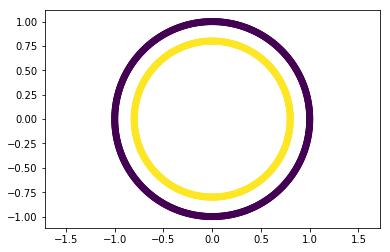

In [4]:
# cercles data
circles_data = np.loadtxt(open('circles.txt','r'))
np.random.seed(0)
indices = np.random.permutation(len(circles_data[:,-1]))
plt.scatter(circles_data[:,0],circles_data[:,1],c=circles_data[:,-1])
plt.axis('equal')

# Separate into train/valid/test with ratio 9:1:1
circles_train_x = circles_data[indices[:900],:-1]
circles_valid_x = circles_data[indices[900:1000],:-1]
circles_test_x = circles_data[indices[1000:],:-1]
circles_train_y = circles_data[indices[:900],-1]
circles_valid_y = circles_data[indices[900:1000],-1]
circles_test_y = circles_data[indices[1000:],-1]
# # Remap y classes to int 1,2
circles_train_y = (circles_train_y).astype(int)
circles_valid_y = (circles_valid_y).astype(int)
circles_test_y = (circles_test_y).astype(int)

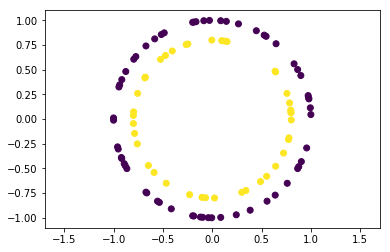

In [5]:
plt.axis('equal')
plt.scatter(circles_test_x[:,0],circles_test_x[:,1],c=circles_test_y)

In [6]:
# GRADED FUNCTION: random_mini_batches [credit to Andrew Ng]

def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (number of examples, feature dimension)
    Y -- "label" vector, of shape (number of examples, 1)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """

    np.random.seed(seed)            # To make your "random" minibatches the same as ours
    m = X.shape[0]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation, :]
    shuffled_Y = Y[permutation, :].reshape((m,1))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k*mini_batch_size : (k+1)*mini_batch_size, :]
        mini_batch_Y = shuffled_Y[k*mini_batch_size : (k+1)*mini_batch_size, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches*mini_batch_size : m, :]
        mini_batch_Y = shuffled_Y[num_complete_minibatches*mini_batch_size : m, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [7]:
def rect(x):
    return np.maximum(0,x)

def softmax(x_v):
    return np.exp(x_v)/np.sum(np.exp(x_v),axis=0)

def cal_accuracy(npa1,npa2):
    return (np.array(npa1)==np.array(npa2)).astype(int).mean()

def cal_error_rate(npa1,npa2):
    return 1-cal_accuracy(npa1,npa2)

class NeuralNetwork:
    def __init__(self,x=None,y=None,d=None,dh=None,m=None):
        # hyperparameters
        self.lmbd11,self.lmbd12,self.lmbd21,self.lmbd22= 0.,0.,0.,0.
        if x is not None:
            self.x = x
            self.y = y
            self.get_n()
            self.set_params(d,dh,m)

            
    def set_params(self,d,dh,m):
        self.d = d
        self.dh = dh # number of hiden layer neurons
        self.m = m # m classes
        self.init_params()
        self.get_n()
    
    def get_n(self):
        try:
            if len(self.x.shape)>1:
                self.n = self.x.shape[1]
            else:
                self.n = 1
        except:
            pass
    
    def init_params(self):
        # Parameter initialization
        np.random.seed(0)
        sqrtr_nc_W1 = 1/self.d**0.5
        self.W1 = np.random.uniform(-sqrtr_nc_W1,sqrtr_nc_W1,(self.dh,self.d))
        self.b1 = np.zeros((self.dh,1))
        sqrtr_nc_W2 = 1/self.dh**0.5
        self.W2 = np.random.uniform(-sqrtr_nc_W2,sqrtr_nc_W2,(self.m,self.dh))
        self.b2 = np.zeros((self.m,1))
        self.wb2theta()
        self.gradFinitDiff = np.zeros(len(self.theta))

    def bprop(self):
        self.theta2wb()
#         import pdb
#         pdb.set_trace()
        self.grad_oa = self.os - np.eye(self.m)[self.y].reshape((self.n,-1)).T
        self.grad_hs = self.W2.T @ self.grad_oa
        self.grad_ha = (self.ha>0).astype(int) * self.grad_hs
        self.grad_x = self.W1.T @ self.grad_ha
        self.grad_b2 = self.grad_oa
        self.grad_W2 = self.grad_oa@ self.hs.reshape((-1,self.n)).T \
        +self.lmbd21*np.sign(self.W2)+2*self.lmbd22*self.W2
        self.grad_b1 = self.grad_ha
        self.grad_W1 = self.grad_ha@ self.x.reshape((-1,self.n)).T \
        +self.lmbd11*np.sign(self.W1)+2*self.lmbd12*self.W1
        
        # Matrix calculus
        if self.n>1:
            self.grad_W2 /= self.n
            self.grad_b2 = np.mean(self.grad_b2,axis=1)
            self.grad_W1 /= self.n
            self.grad_b1 = np.mean(self.grad_b1,axis=1)
        self.serial_grad()

    def fprop(self,ischeck = False, check_theta = None):
        if ischeck == False:
            theta = self.theta
            self.theta2wb()
            W1,b1,W2,b2 = self.W1,self.b1,self.W2,self.b2
        else:
            theta = check_theta
            W1,b1,W2,b2 = self.unserial_param(check_theta)
        
        self.predict(self.x,W1,b1,W2,b2)
        #self.L = -np.log(self.os[self.y])
        self.L = -np.log(np.choose(self.y,self.os))
        self.L_reg = self.L + self.lmbd11*np.sum(np.abs(W1)) \
        + self.lmbd12*np.sum(W1**2) \
        + self.lmbd21*np.sum(np.abs(W2)) \
        + self.lmbd22*np.sum(W2**2)
        self.L_reg = self.L_reg.mean()
        return self.L_reg
    
    def train_loop(self,train_X,train_y,iterations=100,learning_rate=10**-3,K=10,
                   DISPLAY_DETAIL = True, valid_X=None,valid_y=None):
        epsilon_stop = 0.1
        # Get minibatches
        batches_train = random_mini_batches(train_X,train_y.reshape((-1,1)),K)
        batches_n = len(batches_train)
        self.gradBatch = np.zeros((batches_n,len(self.theta)))    
        l_valid_last = SYS_MAX
        for i in tqdm_notebook(range(iterations), desc='epoch'): 
            for ind_b,batch in enumerate(batches_train):
                batch_X = batch[0]
                batch_y = batch[1]
                gradBatch = 0
                for (ind,_) in enumerate(batch_X):
                    self.x = batch_X[ind,:]
                    self.y = batch_y[ind].item()
                    self.n = 1
                    self.fprop()
                    self.bprop()
                    gradBatch += self.gradBprop
                gradBatch /= K
                # Update theta
                self.theta -= gradBatch*learning_rate
                
                # Keep the gradBatch to display
                self.gradBatch[ind_b] = gradBatch
                
            # Early Stop
            # Check the loss over valid
            # if l_valid_cur > l_valid_last
            if valid_X is not None:
                l_valid_cur = self.eval_loss_loop(valid_X, valid_y)
    #             if (l_valid_cur >= l_valid_last) or (np.linalg.norm(gradBatch)<epsilon_stop):
    #                 print_blue("Early Stop.")
    #                 print(l_valid_cur, l_valid_last, np.linalg.norm(gradBatch))
    #                 break
                l_valid_last = l_valid_cur
            if DISPLAY_DETAIL:
                print("#Epoch:{}\t Training Loss:{:.4f}\t Valid Loss:{:.4f} \t Grad_len:{:.4f}".format(
                    i,self.L_reg, l_valid_cur,np.linalg.norm(gradBatch)))
        return
    
    def train(self,train_X,train_y,iterations=100,learning_rate=10**-3,K=10,
                   DISPLAY_DETAIL = True, valid_X=None, valid_y=None, test_X=None, test_y = None):
        
        epsilon_stop = 0.3
        # Get minibatches
        batches_train = random_mini_batches(train_X,train_y.reshape((-1,1)),K)
        batches_n = len(batches_train)
        # Record the gradient of each batch in last epoch
        self.gradBatch = np.zeros((batches_n,len(self.theta)))
        
        # Record the error and average loss in each epoch for train/valid/test data
        # [0]: train / [1]: valid / [2]: test  
        self.epoch_loss = np.zeros((iterations,3))
        self.epoch_error = np.zeros((iterations,3))
        l_valid_last = SYS_MAX
        for i in tqdm_notebook(range(iterations), desc='epoch'): 
            for ind_b,batch in enumerate(batches_train):
                batch_X = batch[0]
                batch_y = batch[1]
                gradBatch = 0
  
                # Calcul batch gradient
                self.x = batch_X.T
                self.y = batch_y.T
                self.n = self.get_n()
                self.fprop()
                self.bprop()
                gradBatch = self.gradBprop
                # Update theta
                self.theta -= gradBatch*learning_rate
                
                # Keep the gradBatch to display
                self.gradBatch[ind_b] = gradBatch
              
            
            self.epoch_loss[i][0] = self.L_reg
            self.epoch_error[i][0] = cal_error_rate(np.argmax(self.os,axis=0), self.y)
            # Early Stop
            # Check the loss over valid
            # if l_valid_cur > l_valid_last
            if valid_X is not None:
                l_valid_cur = self.eval_loss(valid_X, valid_y)
    #             if (l_valid_cur >= l_valid_last) or (np.linalg.norm(gradBatch)<epsilon_stop):
    #                 print_blue("Early Stop.")
    #                 print(l_valid_cur, l_valid_last, np.linalg.norm(gradBatch))
    #                 break
                l_valid_last = l_valid_cur
                self.epoch_loss[i][1] = l_valid_cur
                self.epoch_error[i][1] = self.eval_error(valid_X, valid_y)
            if test_X is not None:
                self.epoch_loss[i][2] = self.eval_loss(test_X, test_y)
                self.epoch_error[i][2] = self.eval_error(test_X, test_y)
            if DISPLAY_DETAIL:
                print("#Epoch:{}\t Training Loss:{:.4f}\t Valid Loss:{:.4f} \t Grad_len:{:.4f}".format(
                    i,self.L_reg, l_valid_cur,np.linalg.norm(gradBatch)))
        return
    
    def predict(self, test_x,W1,b1,W2,b2):
        self.x = test_x
        self.get_n()
        if DEBUG_FLAG:
            print(W1.shape)
            print(self.x.shape)
        self.ha = (W1@self.x).reshape((-1,self.n))+b1
        self.hs = rect(self.ha)
        self.oa = (W2@self.hs).reshape((-1,self.n))+b2
        self.os = softmax(self.oa)
        return np.argmax(self.os,axis=0)
    
    
    def eval_loss_loop(self, data_X, data_y):
        loss = 0
        data_size = data_X.shape[0]
        for i in range(data_size):
            self.x = data_X[i,:]
            self.y = data_y[i]
            loss += self.fprop()
        return loss/data_size
    
    def eval_loss(self, data_X, data_y):
        loss = 0
        data_size = data_X.shape[0]

        model_temp = NeuralNetwork(data_X.T,data_y.reshape((-1,1)).T,self.d,self.dh,self.m)
        model_temp.theta = self.theta
        
        loss = model_temp.fprop()
        
        return np.mean(loss)
    
    def eval_error(self, data_X, data_y):
        predict_list = []
        self.n = self.get_n()
        self.theta2wb()
        predict_list = self.predict(data_X.T,self.W1,self.b1,self.W2,self.b2)
        return cal_error_rate(predict_list,data_y)
        
    def serial_param(self,W1,b1,W2,b2):
        return np.concatenate([np.ravel(W1),
                                     np.ravel(b1),
                                     np.ravel(W2),
                                     np.ravel(b2)])
        
    def unserial_param(self,theta):
        dh = self.dh
        d = self.d
        W1 = theta[0:dh*d].reshape((dh,d))
        b1 = theta[dh*d:dh*d+dh].reshape(-1,1)
        W2 = theta[dh*d+dh:dh*d+dh+m*dh].reshape((m,dh))
        b2 = theta[-m:].reshape(-1,1)
        return W1,b1,W2,b2
    
    def wb2theta(self):
        self.theta = self.serial_param(self.W1,self.b1,self.W2,self.b2)
        
    
    def theta2wb(self):
        self.W1,self.b1,self.W2,self.b2 = self.unserial_param(self.theta)
        
    def serial_grad(self):
        self.gradBprop = np.concatenate([np.ravel(self.grad_W1),
                             np.ravel(self.grad_b1),
                             np.ravel(self.grad_W2),
                             np.ravel(self.grad_b2)])

    def cal_finit_difference(self):
        epsilon = 10**-5
        for ind,t in enumerate(self.theta):
            thetaPlus = np.copy(self.theta)
            thetaPlus[ind] += epsilon
            self.gradFinitDiff[ind] = ((self.fprop(True,thetaPlus)-self.fprop())/epsilon)

    def gradient_check(self):
        ratio = (self.gradFinitDiff+SYS_EPS)/(self.gradBprop+SYS_EPS)
        if np.any(ratio>1.01) or np.any(ratio<0.99):
            print_red("Gradient check failed.")
            print("ratio=",ratio)
        else:
            print_green("Gradient check succeeded.")
    
    def show_two_grads(self):
        print("Gradient Backprop:" ,["{:.4f}".format(x) for x in self.gradBprop])
        print("Gradient Finit Differenct:",["{:.4f}".format(x) for x in self.gradFinitDiff])
        data = np.vstack((self.gradBprop, self.gradFinitDiff))
        df = pd.DataFrame(data)
        display(df)
        return

### 3.1

In [8]:
d = 2
dh = 2
m = 2
model = NeuralNetwork(circles_train_x[0,:],circles_train_y[0],d,dh,m)
model.fprop()
model.bprop()
model.cal_finit_difference()
model.gradient_check()

Gradient check succeeded.


### 3.2

In [ ]:
print(circles_train_x[0,:])
print(circles_train_y[0])
model.show_two_grads()

### 3.3 & 3.4

In [10]:
# mini batch size
K = 10
data_batch_X = circles_train_x[:K,:]
data_batch_y = circles_train_y[:K]
for (ind,_) in enumerate(data_batch_X):
    print("#record:",ind)
    model = NeuralNetwork(data_batch_X[ind,:],data_batch_y[ind],d,dh,m)
    model.set_params(d,dh,m)
    model.fprop()
    model.bprop()
    model.cal_finit_difference()
    model.gradient_check()
    model.show_two_grads()

#record: 0
Gradient check succeeded.
Gradient Backprop: ['0.0000', '0.0000', '0.0000', '0.0000', '-0.0000', '-0.0000', '0.0000', '0.0000', '-0.0000', '0.0000', '0.5000', '-0.5000']
Gradient Finit Differenct: ['0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.5000', '-0.5000']


,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.500000,-0.500000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500001,-0.499999


#record: 1
Gradient check succeeded.
Gradient Backprop: ['0.0032', '0.0095', '0.0568', '0.1683', '0.0101', '0.1776', '-0.1586', '-0.0545', '0.1586', '0.0545', '-0.5108', '0.5108']
Gradient Finit Differenct: ['0.0032', '0.0095', '0.0568', '0.1683', '0.0101', '0.1776', '-0.1586', '-0.0545', '0.1586', '0.0545', '-0.5108', '0.5108']


,0,1,2,3,4,5,6,7,8,9,10,11
0,0.003219,0.009536,0.056813,0.168286,0.010064,0.177617,-0.15856,-0.054464,0.15856,0.054464,-0.510796,0.510796
1,0.003219,0.009536,0.056813,0.168286,0.010064,0.177617,-0.15856,-0.054464,0.15856,0.054464,-0.510795,0.510798


#record: 2
Gradient check succeeded.
Gradient Backprop: ['0.0042', '0.0092', '0.0739', '0.1619', '0.0101', '0.1780', '-0.1563', '-0.0604', '0.1563', '0.0604', '-0.5118', '0.5118']
Gradient Finit Differenct: ['0.0042', '0.0092', '0.0739', '0.1619', '0.0101', '0.1780', '-0.1563', '-0.0604', '0.1563', '0.0604', '-0.5118', '0.5118']


,0,1,2,3,4,5,6,7,8,9,10,11
0,0.004189,0.009172,0.073925,0.161874,0.010084,0.177955,-0.156346,-0.060445,0.156346,0.060445,-0.511770,0.511770
1,0.004189,0.009172,0.073925,0.161874,0.010084,0.177956,-0.156346,-0.060445,0.156346,0.060445,-0.511769,0.511771


#record: 3
Gradient check succeeded.
Gradient Backprop: ['0.0100', '-0.0012', '0.1769', '-0.0203', '0.0101', '0.1781', '-0.0174', '-0.0702', '0.0174', '0.0702', '-0.5121', '0.5121']
Gradient Finit Differenct: ['0.0100', '-0.0012', '0.1769', '-0.0203', '0.0101', '0.1781', '-0.0174', '-0.0702', '0.0174', '0.0702', '-0.5121', '0.5121']


,0,1,2,3,4,5,6,7,8,9,10,11
0,0.010024,-0.00115,0.176905,-0.020298,0.01009,0.178066,-0.017356,-0.070231,0.017356,0.070231,-0.512087,0.512087
1,0.010024,-0.00115,0.176905,-0.020298,0.01009,0.178066,-0.017356,-0.070231,0.017356,0.070231,-0.512086,0.512088


#record: 4
Gradient check succeeded.
Gradient Backprop: ['0.0000', '0.0000', '0.0000', '0.0000', '-0.0000', '-0.0000', '0.0000', '0.0000', '-0.0000', '0.0000', '0.5000', '-0.5000']
Gradient Finit Differenct: ['0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.5000', '-0.5000']


,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.500000,-0.500000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500001,-0.499999


#record: 5
Gradient check succeeded.
Gradient Backprop: ['-0.0077', '0.0007', '-0.1358', '0.0124', '-0.0097', '-0.1704', '0.0161', '0.0545', '-0.0161', '-0.0545', '0.4902', '-0.4902']
Gradient Finit Differenct: ['-0.0077', '0.0007', '-0.1358', '0.0124', '-0.0097', '-0.1704', '0.0161', '0.0545', '-0.0161', '-0.0545', '0.4902', '-0.4902']


,0,1,2,3,4,5,6,7,8,9,10,11
0,-0.007694,0.000705,-0.135789,0.012445,-0.009658,-0.170447,0.016066,0.05448,-0.016066,-0.05448,0.490178,-0.490178
1,-0.007694,0.000705,-0.135789,0.012445,-0.009658,-0.170447,0.016066,0.05448,-0.016066,-0.05448,0.490179,-0.490177


#record: 6
Gradient check succeeded.
Gradient Backprop: ['0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '-0.0000', '0.0000', '0.0000', '0.0000', '-0.5000', '0.5000']
Gradient Finit Differenct: ['0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '-0.5000', '0.5000']


,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.500000,0.500000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.499999,0.500001


#record: 7
Gradient check succeeded.
Gradient Backprop: ['0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '-0.0000', '0.0000', '0.0000', '0.0000', '-0.5000', '0.5000']
Gradient Finit Differenct: ['0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '-0.5000', '0.5000']


,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.500000,0.500000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.499999,0.500001


#record: 8
Gradient check succeeded.
Gradient Backprop: ['-0.0074', '-0.0023', '-0.1299', '-0.0398', '-0.0096', '-0.1698', '0.0606', '0.0616', '-0.0606', '-0.0616', '0.4884', '-0.4884']
Gradient Finit Differenct: ['-0.0074', '-0.0023', '-0.1299', '-0.0398', '-0.0096', '-0.1698', '0.0606', '0.0616', '-0.0606', '-0.0616', '0.4884', '-0.4884']


,0,1,2,3,4,5,6,7,8,9,10,11
0,-0.007362,-0.002253,-0.129923,-0.039767,-0.009624,-0.169841,0.060596,0.06156,-0.060596,-0.06156,0.488435,-0.488435
1,-0.007362,-0.002253,-0.129923,-0.039767,-0.009624,-0.169841,0.060596,0.06156,-0.060596,-0.06156,0.488436,-0.488433


#record: 9
Gradient check succeeded.
Gradient Backprop: ['0.0095', '0.0034', '0.1685', '0.0601', '0.0101', '0.1789', '-0.0861', '-0.0814', '0.0861', '0.0814', '-0.5146', '0.5146']
Gradient Finit Differenct: ['0.0095', '0.0034', '0.1685', '0.0601', '0.0101', '0.1789', '-0.0861', '-0.0814', '0.0861', '0.0814', '-0.5146', '0.5146']


,0,1,2,3,4,5,6,7,8,9,10,11
0,0.009549,0.003407,0.168524,0.060129,0.010139,0.17893,-0.086081,-0.08141,0.086081,0.08141,-0.514573,0.514573
1,0.009549,0.003407,0.168524,0.060129,0.010139,0.17893,-0.086081,-0.08141,0.086081,0.08141,-0.514572,0.514574


### 3.5

In [11]:
d = 2
dh = 8
m = 2
model_3_5 = NeuralNetwork()
model_3_5.set_params(d,dh,m)
model_3_5.train_loop(circles_train_x, circles_train_y, 100, 10**-2, 10, True,
                     circles_valid_x, circles_valid_y)

predict_list = []
for x in circles_test_x:
    predict_list.append(model_3_5.predict(x,model_3_5.W1,model_3_5.b1,model_3_5.W2,model_3_5.b2).item())

print("Accuracy:",cal_accuracy(predict_list,circles_test_y))

#Epoch:0	 Training Loss:0.6570	 Valid Loss:0.6960 	 Grad_len:0.3253
#Epoch:1	 Training Loss:0.6671	 Valid Loss:0.6930 	 Grad_len:0.3334
#Epoch:2	 Training Loss:0.6726	 Valid Loss:0.6911 	 Grad_len:0.3380
#Epoch:3	 Training Loss:0.6754	 Valid Loss:0.6897 	 Grad_len:0.3407
#Epoch:4	 Training Loss:0.6766	 Valid Loss:0.6885 	 Grad_len:0.3424
#Epoch:5	 Training Loss:0.6770	 Valid Loss:0.6876 	 Grad_len:0.3435
#Epoch:6	 Training Loss:0.6769	 Valid Loss:0.6867 	 Grad_len:0.3445
#Epoch:7	 Training Loss:0.6766	 Valid Loss:0.6858 	 Grad_len:0.3453
#Epoch:8	 Training Loss:0.6761	 Valid Loss:0.6850 	 Grad_len:0.3461
#Epoch:9	 Training Loss:0.6755	 Valid Loss:0.6842 	 Grad_len:0.3470
#Epoch:10	 Training Loss:0.6749	 Valid Loss:0.6835 	 Grad_len:0.3479
#Epoch:11	 Training Loss:0.6744	 Valid Loss:0.6826 	 Grad_len:0.3489
#Epoch:12	 Training Loss:0.6738	 Valid Loss:0.6818 	 Grad_len:0.3500
#Epoch:13	 Training Loss:0.6734	 Valid Loss:0.6810 	 Grad_len:0.3513
#Epoch:14	 Training Loss:0.6729	 Valid Loss:

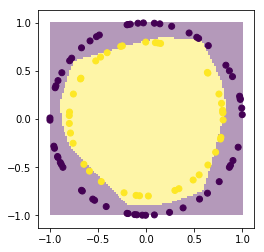

In [12]:
# Draw decision boundary
range_x1 = np.linspace(-1,1,100)
range_x2 = range_x1 
xx1,xx2 = np.meshgrid(range_x1, range_x2)
data = np.c_[xx1.ravel(),xx2.ravel()]

plot_list = []
for d in data:
    plot_list.append(model_3_5.predict(d,model_3_5.W1,model_3_5.b1,model_3_5.W2,model_3_5.b2))
Z = np.array(plot_list).reshape(xx1.shape)

plt.imshow(Z, extent=(xx1.min(), xx1.max(), xx2.min(), xx2.max()), alpha=.4, origin='lower')
plt.scatter(circles_test_x[:,0],circles_test_x[:,1],c=circles_test_y)

### 3.6

In [13]:
d = 2
dh = 8
m = 2
model_3_6 = NeuralNetwork()
model_3_6.set_params(d,dh,m)
model_3_6.train(circles_train_x, circles_train_y, 100, 10**-2, 10, True,
                circles_valid_x, circles_valid_y, circles_test_x, circles_test_y)

#Epoch:0	 Training Loss:0.6714	 Valid Loss:0.6960 	 Grad_len:0.3253
#Epoch:1	 Training Loss:0.6739	 Valid Loss:0.6930 	 Grad_len:0.3334
#Epoch:2	 Training Loss:0.6745	 Valid Loss:0.6911 	 Grad_len:0.3380
#Epoch:3	 Training Loss:0.6741	 Valid Loss:0.6897 	 Grad_len:0.3407
#Epoch:4	 Training Loss:0.6731	 Valid Loss:0.6885 	 Grad_len:0.3424
#Epoch:5	 Training Loss:0.6717	 Valid Loss:0.6876 	 Grad_len:0.3435
#Epoch:6	 Training Loss:0.6701	 Valid Loss:0.6867 	 Grad_len:0.3445
#Epoch:7	 Training Loss:0.6684	 Valid Loss:0.6858 	 Grad_len:0.3453
#Epoch:8	 Training Loss:0.6666	 Valid Loss:0.6850 	 Grad_len:0.3461
#Epoch:9	 Training Loss:0.6648	 Valid Loss:0.6842 	 Grad_len:0.3470
#Epoch:10	 Training Loss:0.6630	 Valid Loss:0.6835 	 Grad_len:0.3479
#Epoch:11	 Training Loss:0.6611	 Valid Loss:0.6826 	 Grad_len:0.3489
#Epoch:12	 Training Loss:0.6593	 Valid Loss:0.6818 	 Grad_len:0.3500
#Epoch:13	 Training Loss:0.6574	 Valid Loss:0.6810 	 Grad_len:0.3513
#Epoch:14	 Training Loss:0.6556	 Valid Loss:

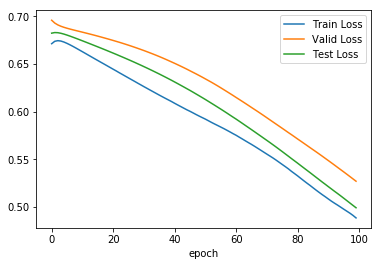

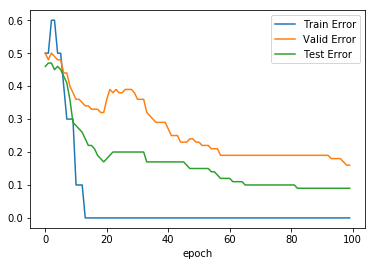

In [14]:
labels = ['Train Loss','Valid Loss','Test Loss']
for d, label in zip(model_3_6.epoch_loss.T, labels):
    plt.plot(d, label=label)
plt.xlabel("epoch")
plt.legend()
plt.show()
labels = ['Train Error','Valid Error','Test Error']
for d, label in zip(model_3_6.epoch_error.T, labels):
    plt.plot(d, label=label)
plt.xlabel("epoch")
plt.legend()
plt.show()

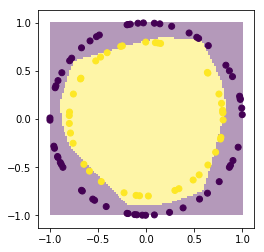

In [15]:
# Draw decision boundary
range_x1 = np.linspace(-1,1,100)
range_x2 = range_x1 
xx1,xx2 = np.meshgrid(range_x1, range_x2)
data = np.c_[xx1.ravel(),xx2.ravel()]
model_3_6.n = data.shape[0]
plot_list = model_3_6.predict(data.T,model_3_6.W1,model_3_6.b1,model_3_6.W2,model_3_6.b2)
Z = np.array(plot_list).reshape(xx1.shape)

plt.imshow(Z, extent=(xx1.min(), xx1.max(), xx2.min(), xx2.max()), alpha=.4, origin='lower')
plt.scatter(circles_test_x[:,0],circles_test_x[:,1],c=circles_test_y)

### 3.7

In [16]:
d = 2
dh = 2
m = 2
max_iteratiosns = 2
learning_rate = 10**-2

X = circles_train_x
y = circles_train_y

grads_table = {"K1":{},"K10":{}}

for K in [1,10]:
    model_loop = NeuralNetwork()
    model_loop.set_params(d,dh,m)
    model_loop.train_loop(X, y, max_iteratiosns, learning_rate , K, 
                          False, circles_valid_x, circles_valid_y)
    grads_table["K{}".format(K)]["loop"] = model_loop.gradBatch
    
    model_matrix = NeuralNetwork()
    model_matrix.set_params(d,dh,m)
    model_matrix.train(X, y, max_iteratiosns, learning_rate, K, 
                          False, circles_valid_x, circles_valid_y)
    grads_table["K{}".format(K)]["matrix"] = model_matrix.gradBatch


In [17]:
df_K1_loop = pd.DataFrame(grads_table["K1"]["loop"])
df_K1_matrix = pd.DataFrame(grads_table["K1"]["matrix"])
df_K10_loop = pd.DataFrame(grads_table["K10"]["loop"])
df_K10_matrix = pd.DataFrame(grads_table["K10"]["matrix"])

#### K=1

##### a) Gradients of Loop method

In [18]:
display(df_K1_loop)

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.000000,0.000000,-0.087634,0.094396,0.000000,-0.161005,0.000000,0.004799,0.000000,-0.004799,0.555743,-0.555743
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.553616,-0.553616
2,0.035569,-0.021173,0.000000,0.000000,-0.041393,0.000000,-0.043801,0.000000,0.043801,0.000000,-0.446877,0.446877
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.553088,-0.553088
4,0.000000,0.000000,0.111914,-0.068361,0.000000,0.131141,0.000000,-0.018063,0.000000,0.018063,-0.452512,0.452512
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.552591,-0.552591
6,0.040063,0.008835,-0.124018,-0.027350,0.051283,-0.158748,0.063504,0.031238,-0.063504,-0.031238,0.548456,-0.548456
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.547140,-0.547140
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.455572,0.455572
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.453313,0.453313


##### b) Gradients of Matrix calculus method

In [19]:
display(df_K1_matrix)

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.000000,0.000000,-0.087634,0.094396,0.000000,-0.161005,0.000000,0.004799,-0.000000,-0.004799,0.555743,-0.555743
1,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.553616,-0.553616
2,0.035569,-0.021173,0.000000,0.000000,-0.041393,0.000000,-0.043801,0.000000,0.043801,0.000000,-0.446877,0.446877
3,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.553088,-0.553088
4,0.000000,0.000000,0.111914,-0.068361,-0.000000,0.131141,-0.000000,-0.018063,0.000000,0.018063,-0.452512,0.452512
5,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.552591,-0.552591
6,0.040063,0.008835,-0.124018,-0.027350,0.051283,-0.158748,0.063504,0.031238,-0.063504,-0.031238,0.548456,-0.548456
7,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.547140,-0.547140
8,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.455572,0.455572
9,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.453313,0.453313


##### c) Check equality of the gradients of both methods

In [20]:
ratio = (grads_table["K1"]["loop"]+SYS_EPS) / (grads_table["K1"]["matrix"]+SYS_EPS)
np.all(ratio<1.01) and  np.all(ratio >0.99)

True

#### K=10

##### a) Gradients of Loop method

In [21]:
display(df_K10_loop)

,0,1,2,3,4,5,6,7,8,9,10,11
0,-0.000747,0.000156,-0.000307,-0.017181,4.688809e-06,0.000351,0.000444,0.003178,-0.000444,-0.003178,0.100547,-0.100547
1,0.000205,0.000041,-0.032368,0.036602,-9.150166e-04,-0.033718,-0.002896,0.006409,0.002896,-0.006409,0.099909,-0.099909
2,-0.000220,0.000484,-0.013471,0.026281,1.330950e-05,-0.016410,-0.014433,0.000739,0.014433,-0.000739,-0.001169,0.001169
3,-0.000785,0.000421,-0.033634,0.030387,2.166480e-05,-0.050237,-0.008344,0.008071,0.008344,-0.008071,0.097773,-0.097773
4,-0.000938,0.000406,0.005003,0.005660,4.417569e-04,0.018016,-0.006739,-0.002949,0.006739,0.002949,-0.102131,0.102131
5,-0.000378,0.000458,-0.011702,0.017346,8.714889e-04,0.000853,-0.013202,0.001762,0.013202,-0.001762,-0.001493,0.001493
6,0.001018,-0.000368,0.031447,-0.012276,-8.145312e-04,0.017897,0.005011,-0.010644,-0.005011,0.010644,-0.001521,0.001521
7,-0.000010,-0.000320,-0.005380,-0.004039,3.295163e-05,-0.049743,0.011685,0.002603,-0.011685,-0.002603,0.196017,-0.196017
8,-0.000184,-0.000063,-0.002468,-0.026528,-8.462263e-04,0.017837,0.003670,0.005735,-0.003670,-0.005735,0.098175,-0.098175
9,0.001160,0.000152,0.016662,0.032704,4.575527e-04,0.001038,-0.014516,-0.012558,0.014516,0.012558,0.197092,-0.197092


##### b) Gradients of Matrix calculus method

In [22]:
display(df_K10_matrix)

,0,1,2,3,4,5,6,7,8,9,10,11
0,-0.000747,0.000156,-0.000307,-0.017181,4.688809e-06,0.000351,0.000444,0.003178,-0.000444,-0.003178,0.100547,-0.100547
1,0.000205,0.000041,-0.032368,0.036602,-9.150166e-04,-0.033718,-0.002896,0.006409,0.002896,-0.006409,0.099909,-0.099909
2,-0.000220,0.000484,-0.013471,0.026281,1.330950e-05,-0.016410,-0.014433,0.000739,0.014433,-0.000739,-0.001169,0.001169
3,-0.000785,0.000421,-0.033634,0.030387,2.166480e-05,-0.050237,-0.008344,0.008071,0.008344,-0.008071,0.097773,-0.097773
4,-0.000938,0.000406,0.005003,0.005660,4.417569e-04,0.018016,-0.006739,-0.002949,0.006739,0.002949,-0.102131,0.102131
5,-0.000378,0.000458,-0.011702,0.017346,8.714889e-04,0.000853,-0.013202,0.001762,0.013202,-0.001762,-0.001493,0.001493
6,0.001018,-0.000368,0.031447,-0.012276,-8.145312e-04,0.017897,0.005011,-0.010644,-0.005011,0.010644,-0.001521,0.001521
7,-0.000010,-0.000320,-0.005380,-0.004039,3.295163e-05,-0.049743,0.011685,0.002603,-0.011685,-0.002603,0.196017,-0.196017
8,-0.000184,-0.000063,-0.002468,-0.026528,-8.462263e-04,0.017837,0.003670,0.005735,-0.003670,-0.005735,0.098175,-0.098175
9,0.001160,0.000152,0.016662,0.032704,4.575527e-04,0.001038,-0.014516,-0.012558,0.014516,0.012558,0.197092,-0.197092


##### c) Check equality of the gradients of both methods

In [23]:
ratio = (grads_table["K10"]["loop"]+SYS_EPS) / (grads_table["K10"]["matrix"]+SYS_EPS)
np.all(ratio<1.01) and  np.all(ratio >0.99)

True

### 3.8

In [24]:
# fashion MNIST
import utils.mnist_reader as mnist_reader
X_train, y_train = mnist_reader.load_mnist('data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')

In [25]:
print(X_train.shape)
print(y_train.shape)

(60000, 784)
(60000,)


In [26]:
n = len(y_train)
indices = np.random.permutation(n)
SP_PT = int(n*0.9)
X_valid = X_train[SP_PT:,:]
y_valid = y_train[SP_PT:]
X_train = X_train[:SP_PT,:]
y_train = y_train[:SP_PT]

In [27]:
print(X_valid.shape)
print(y_valid.shape)
print(X_train.shape)
print(y_train.shape)

(6000, 784)
(6000,)
(54000, 784)
(54000,)


In [28]:
d = 784
dh = 2
m = 10
max_iteratiosns = 1
learning_rate = 10**-2

X = X_train
y = y_train

K=100

In [29]:
%%time
model_loop = NeuralNetwork()
model_loop.set_params(d,dh,m)
model_loop.train_loop(X, y, max_iteratiosns, learning_rate , K, 
                      False, X_valid, y_valid)


CPU times: user 13.9 s, sys: 113 ms, total: 14 s
Wall time: 14.2 s


In [30]:
%%time
model_matrix = NeuralNetwork()
model_matrix.set_params(d,dh,m)
model_matrix.train(X, y, max_iteratiosns, learning_rate, K, 
                      False, X_valid, y_valid)


CPU times: user 1.19 s, sys: 205 ms, total: 1.39 s
Wall time: 744 ms


 #### Comparison
 - One epoch with Loop method takes around 13.7s
 - One epoch with Matrix Calculus method takes around 473ms

### 3.9 & 3.10

In [ ]:
d = 784
dh = 64
m = 10
max_iteratiosns = 400
learning_rate = 10**-3

X = X_train
y = y_train

K=64

model_3_10 = NeuralNetwork()
model_3_10.set_params(d,dh,m)
model_3_10.train(X, y, max_iteratiosns, learning_rate, K, 
                      False, X_valid, y_valid, X_test, y_test)

labels = ['Train Loss','Valid Loss','Test Loss']
for d, label in zip(model_3_10.epoch_loss.T, labels):
    plt.plot(d, label=label)
plt.xlabel("epoch")
plt.legend()
plt.show()
labels = ['Train Error','Valid Error','Test Error']
for d, label in zip(model_3_10.epoch_error.T, labels):
    plt.plot(d, label=label)
plt.xlabel("epoch")
plt.legend()
plt.show()